In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import re
import math
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer, normalize
from sklearn.cluster import KMeans, DBSCAN
from sklearn import metrics
from hdbscan import HDBSCAN, validity_index
from urllib.parse import urlparse
from collections import Counter

In [2]:
np.random.seed(42)

In [3]:
# Some useful method we will use from this point
# There is no need to understand them fully to grasp the reasoning below

def kmeans(X, k):
    return KMeans(
            n_clusters=k,
            init="k-means++",
            max_iter=100,
            n_init=1,
    ).fit_predict(X)

def dbscan(X, eps, min_samples):
    return HDBSCAN(min_cluster_size=min_samples, cluster_selection_epsilon=float(eps)).fit_predict(X)

def s_score(X, labels):
    X_no_noise = X[labels != -1]
    labels_no_noise = labels[labels != -1]
    if len(set(labels_no_noise)) < 2:
        return 0
    return metrics.silhouette_score(X_no_noise, labels_no_noise, random_state=42, sample_size=1000)

def dbcv_score(X, labels):
    X_no_noise = X[labels != -1]
    labels_no_noise = labels[labels != -1]
    if len(set(labels_no_noise)) < 2:
        return 0
    return validity_index(X_no_noise, labels_no_noise)

def plot_clusters(X, labels_list, titles, rows, cols):
    assert len(labels_list) == len(titles)
    assert len(labels_list) <= rows * cols
    
    fig, axs = plt.subplots(rows, cols, figsize=(15, 15), sharey=True, sharex=True)
    for i, (labels, title) in enumerate(zip(labels_list, titles)):
        ax = axs[i // cols, i % cols]
        ax.scatter(X[:,0], X[:,1], c=labels, alpha=0.6)
        ax.set_title(title)

def clusters_top_elements(labels, values_and_weights, n_samples = 10):
    for label in sorted(set(labels[labels >= 0])):
        members = values_and_weights[labels == label]
        sample_size = min(len(members), n_samples)
        print(f"\nCluster {label} ({len(members)} elements)")
        print(members.nlargest(sample_size, columns=["qids"]))

def dbscan_cluster_count(labels):
    return len(set(labels)) - (1 if -1 in labels else 0)
    

def dbscan_cluster_size_plot(X, labels, media_names):
    n_clusters = dbscan_cluster_count(labels)
    n_noise = list(labels).count(-1)

    print(f"{n_clusters} clusters")
    print(f"Some noise: {n_noise / len(labels) * 100:0.1f}%" if n_noise else "No noise")
    print(f"DBCV score: {dbcv_score(X, labels):0.2f}")
    clusters_top_elements(labels, media_names)
        
    pd.Series(Counter(labels)).plot.bar(title="Cluster sizes", xlabel="Cluster index", ylabel="Publisher count")
    
def dbscan_grid_plot(eps_values, ms_values, metrics, metric_index, title):
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow([[metrics[eps, ms][metric_index] for ms in ms_values] for eps in eps_values])

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(ms_values)), labels=ms_values)
    ax.set_yticks(np.arange(len(eps_values)), labels=eps_values)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i, eps in enumerate(eps_values):
        for j, ms in enumerate(ms_values):
            text = ax.text(j, i, f"{metrics[eps, ms][metric_index]:0.2f}", ha="center", va="center", color="w")

    ax.set_title(title)
    plt.show()

def make_lsa(dims):
    svd = TruncatedSVD(int(dims), random_state=42)
    normalizer = Normalizer(copy=False)
    return (svd, make_pipeline(svd, normalizer))

def fit_and_get_var(X, svd, lsa):
    lsa.fit(X)
    return svd.explained_variance_ratio_.sum()

# Clustering

This part of the project uses the cleaned dataset extracted in the previous notebook. With data cleaning out of the way, the next step for our analysis is clustering. In this section, we explore different clustering methods and parameters and do a evaluate the quality of results. Clustering will be done based on the number of time a speaker has been quoted by a publisher.

In [4]:
df = pd.read_csv("../data/clean_quotes.csv.bz2", usecols=["qids", "journal"])

In [5]:
df.head()

,qids,journal
0,Q20684375,people.com
1,Q20684375,people.com
2,Q20684375,people.com
3,Q20684375,people.com
4,Q20684375,people.com


We first count the number of occurences of a speaker for each publisher. 

In [6]:
speakers_by_media = df.groupby("journal")
speakers_by_media_count = speakers_by_media.agg({"qids": Counter})

print(f"Media entities: {len(speakers_by_media)}")

Media entities: 5734


We then create vectors from these counts

In [7]:
vectorizer = DictVectorizer()
X = vectorizer.fit_transform(speakers_by_media_count["qids"])

print(f"News outlets vector size: {X.shape[1]}")

News outlets vector size: 40753


The resulting matrix is probably very sparse. Let's verify that.

In [8]:
print(f"Matrix sparsity: {1 - X.count_nonzero() / (X.shape[0] * X.shape[1])}")

Matrix sparsity: 0.9936292894561245


Since the data is very high dimensional, we first apply dimensionality reduction. We use `TruncatedSVD`, which works with sparse data. Afterwards, we normalize the data. This combination is known as [latent semantic analysis](https://en.wikipedia.org/wiki/Latent_semantic_analysis). However, there is a trade-off when choosing the number of dimensions. Few dimensions make it easy to cluster and avoid the curse of dimensionality, but might not retain the full structure of the vectors. A simple way to verify this is to compute the explained variance. We decided that a 95% explained variance was sufficient.

In [9]:
dims_values = [2, 3, 5, 10, 20, 30, 40, 50, 100, 200]
lsas = [make_lsa(dims) for dims in dims_values]
svds_explained_variance = [fit_and_get_var(X, svd, lsa) for svd, lsa in lsas]

First dimension with 95%+ explained variance: 30 (variance 0.9504)


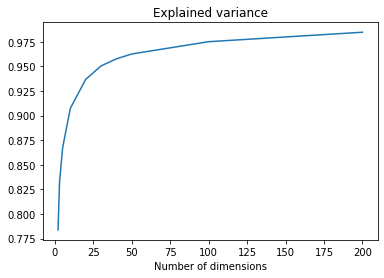

In [10]:
pd.Series(index=dims_values, data=svds_explained_variance).plot(title="Explained variance", xlabel="Number of dimensions")

dim_95, explained_var_95 = next((dims_values[i], var) for i, var in enumerate(svds_explained_variance) if var >= 0.95)
print(f"First dimension with 95%+ explained variance: {dim_95} (variance {explained_var_95:0.4f})")

We apply LSA to our newspapers-speaker matrix and also prepare 2d and 3d versions for visualization.

In [11]:
svd = TruncatedSVD(dim_95, random_state=42)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

X_intermediate = lsa.fit_transform(X)
X_3d = PCA(n_components=3).fit_transform(X_intermediate)
X_2d = PCA(n_components=2).fit_transform(X_intermediate)

## KMeans

We first try clustering using KMeans with a range of values for k. We observe the best silouhette score with k=3

In [13]:
k_list = range(2, 22)

kmeans_labels = [kmeans(X_intermediate, k) for k in k_list]
kmeans_titles = [f"k = {k}" for k in k_list]

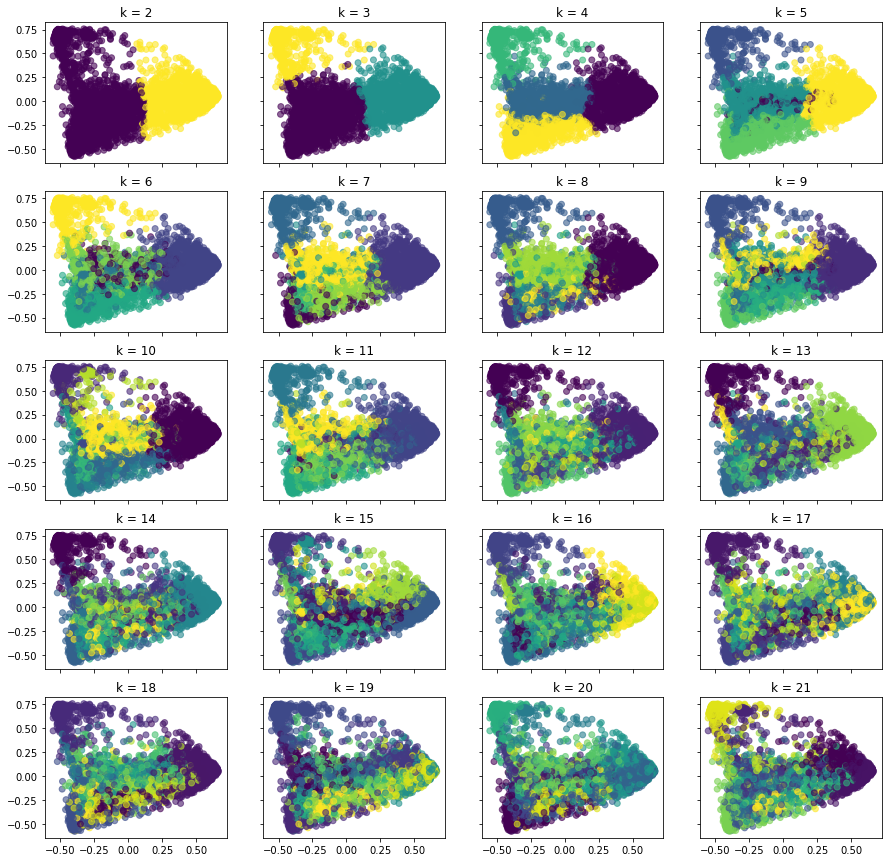

In [14]:
plot_clusters(X_2d, kmeans_labels, kmeans_titles, 5, 4)

Visualizations are not very helpful. Let's estimate the clustering quality using silhouette score.

Best value for k: 18
Best silhouette score: 0.320


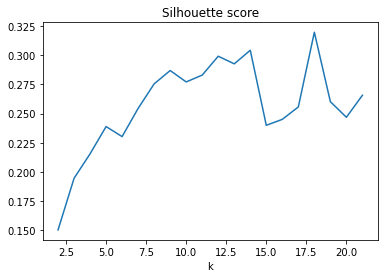

In [15]:
silhouette_scores = pd.Series(index=k_list, data=[s_score(X_intermediate, labels) for labels in kmeans_labels])

best_k = silhouette_scores.idxmax()
best_score = silhouette_scores.max()
silhouette_scores.plot(title="Silhouette score", xlabel="k")
print(f"Best value for k: {best_k}")
print(f"Best silhouette score: {best_score:0.3f}")

Showing biggest publishers for each cluster when k=18 to get a sense of what the clusters are made of. Most clusters appear to be geographic. The distribution of publishers between clusters is more or less balanced, with the exception of cluster 1.


Cluster 0 (244 elements)
                          qids
journal                       
eurekalert.org            3334
crainsdetroit.com          870
wvmetronews.com            746
orlandoweekly.com          727
chicagobusiness.com        670
wctv.tv                    585
bringmethenews.com         504
augustafreepress.com       486
cltampa.com                471
parkrapidsenterprise.com   464

Cluster 1 (1555 elements)
                       qids
journal                    
msn.com              105439
news965.com           56492
breitbart.com         53553
wokv.com              46676
washingtontimes.com   38527
foxnews.com           36557
wsbradio.com          34051
krmg.com              31864
nytimes.com           31798
sfgate.com            29339

Cluster 2 (613 elements)
                           qids
journal                        
express.co.uk             20147
mirror.co.uk              18427
bucksfreepress.co.uk      14511
eveningtimes.co.uk        13753
expressandstar.com   

<AxesSubplot:title={'center':'Cluster sizes'}, xlabel='Cluster index', ylabel='Publisher count'>

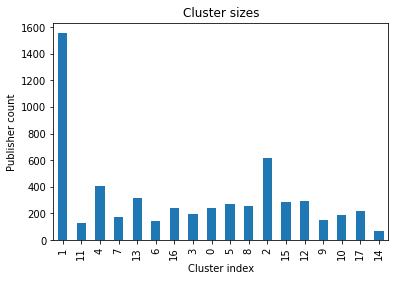

In [25]:
media_count = df.groupby("journal").count()
clusters_top_elements(kmeans_labels[best_k - 2], media_count)
pd.Series(Counter(kmeans_labels[best_k - 2])).plot.bar(title="Cluster sizes", xlabel="Cluster index", ylabel="Publisher count")

However, there are problems with K-Means:

- The main issue is that K-Means is not equiped to deal with noise. 
- It might be difficult to discover small niche clusters with K-Means.

DBScan does not have these downsides. Let's try it.

## DBScan

We now try to use DBSCAN, adjusting `eps` and `min_samples` parameters to get a sense of how it affects the results. To estimate the clustering quality, we use DBCV, a metric tailored to DBSCAN.

In [17]:
eps_values = [round(eps, 3) for eps in np.linspace(0.2, 0.4, 5)]
min_samples_values = np.linspace(10, 40, 11)
parameters = [(eps, min_samples) for eps in eps_values for min_samples in min_samples_values]

In [18]:
print("Clustering...")
dbscan_labels = [dbscan(X_intermediate, eps, int(ms)) for eps, ms in parameters]
print("Computing DBCV scores...")
dbscan_metrics = {(eps, ms): (dbcv_score(X_intermediate, labels), dbscan_cluster_count(labels)) for (eps, ms), labels in zip(parameters, dbscan_labels)}
print("Done")

Clustering...
Computing DBCV scores...
Done


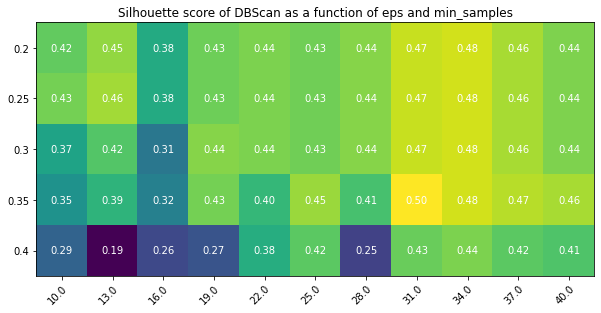

Best eps: 0.35, best min_samples: 31.0
Number of clusters: 15


In [19]:
dbscan_grid_plot(eps_values, min_samples_values, dbscan_metrics, 0, "Silhouette score of DBScan as a function of eps and min_samples")
best_eps, best_ms = max(dbscan_metrics, key=dbscan_metrics.get)
print(f"Best eps: {best_eps}, best min_samples: {best_ms}")
print(f"Number of clusters: {dbscan_metrics[best_eps, best_ms][1]}")

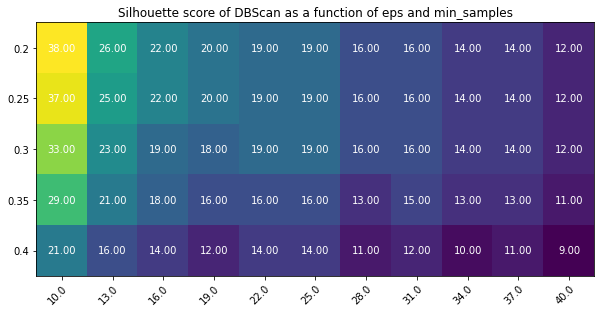

In [20]:
dbscan_grid_plot(eps_values, min_samples_values, dbscan_metrics, 1, "Silhouette score of DBScan as a function of eps and min_samples")

Similarly, we examine the case where eps=0.16 in more details.

In [21]:
final_eps = best_eps
final_ms = best_ms

15 clusters
Some noise: 50.6%
DBCV score: 0.50

Cluster 0 (33 elements)
                          qids
journal                       
gamereactor.eu            5969
gamesindustry.biz          260
usgamer.net                198
gamingbolt.com             187
playstationlifestyle.net   147
gamerant.com               140
videogamer.com             133
gamasutra.com              130
igamingbusiness.com        130
pcgamesn.com               130

Cluster 1 (39 elements)
                        qids
journal                     
ncregister.com          1773
catholicnewsagency.com  1642
cruxnow.com             1540
ncronline.org           1395
thebostonpilot.com      1176
catholicphilly.com       849
ecowatch.com             722
churchmilitant.com       691
catholicherald.co.uk     625
christiantoday.com       620

Cluster 2 (49 elements)
                         qids
journal                      
breakingnews.ie         18328
independent.ie          12253
irishexaminer.com       11713
irishtim

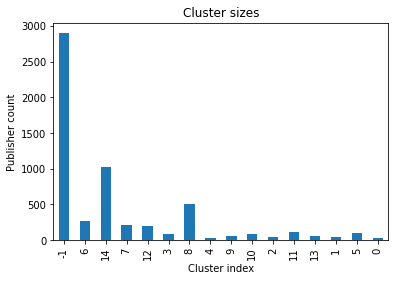

In [22]:
dbscan_best_labels = dbscan_labels[parameters.index((final_eps, final_ms))]
dbscan_cluster_size_plot(X_intermediate, dbscan_best_labels, media_count)

With DBScan, the distribution of publisher across clusters is a lot less uniform and our choice of parameters also results in a lot of noise. However, the top elements of clusters are more uniform than K-means'.

In [23]:
data = np.concatenate((dbscan_best_labels.reshape((-1, 1)), X_3d_aligned), axis=1)
columns_names = ['cluster_id', 'x', 'y', 'z']
clustered_media = pd.DataFrame(index=media_count.index, columns=columns_names, data=data)
display(clustered_media)

,cluster_id,x,y,z
journal,,,,
1011now.com,-1.0,-0.514054,0.088537,-0.162709
1070thefan.com,-1.0,0.333378,0.319923,0.126778
107jamz.com,6.0,0.141768,0.487365,-0.429182
10news.com,14.0,-0.578850,0.043942,-0.089970
1130thetiger.com,-1.0,-0.098064,0.328662,-0.101700
...,...,...,...,...
zalebs.com,-1.0,0.361444,0.331258,0.294870
zawya.com,14.0,-0.507999,-0.299231,0.086460
zdnet.com,-1.0,-0.010641,-0.384200,0.328471


In [24]:
clustered_media.to_csv("../data/clusters.csv.bz2")

## Conclusion

Applying DBScan on our clean version of quotebank yields good, multi facetted clusters that would be ripe for further analysis. KMeans in comparison seems to have more problems dealing with noise. With a little bit more time, we would also like to try other clustering methods, like agglomerative clustering for example.